# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from IPython.display import display

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [ ]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [ ]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [ ]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

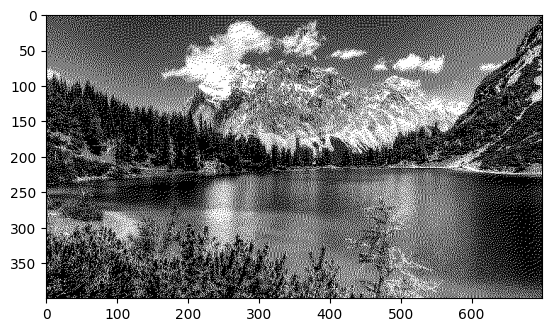

In [ ]:
image = Image.open('/content/image (1).jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

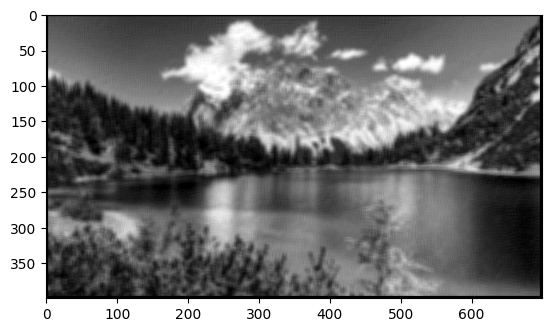

In [ ]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [ ]:
from PIL import Image

img = Image.open('/content/image (1).jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

<ipython-input-8-cebfc8cc3a26>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.


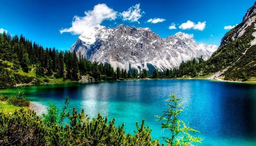

In [ ]:
img

In [ ]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [ ]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [ ]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

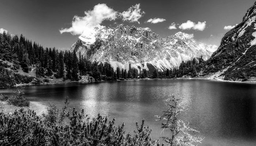

In [ ]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [ ]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [ ]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.0662,  0.0341,  0.0323,  ...,  0.0407,  0.0807,  0.2147],
         [-0.0509, -0.0431, -0.0411,  ..., -0.0281,  0.0504,  0.0495],
         [-0.0542, -0.0401, -0.0365,  ...,  0.0220,  0.0257, -0.0176],
         ...,
         [ 0.0158, -0.0632, -0.0372,  ..., -0.0352, -0.0371,  0.0531],
         [-0.0833, -0.0832,  0.0421,  ..., -0.0439, -0.0504,  0.0453],
         [ 0.0095,  0.0745,  0.0715,  ...,  0.0997,  0.1011,  0.0849]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [ ]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [ ]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [ ]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [ ]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

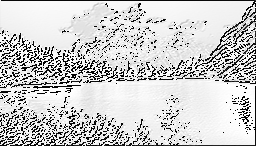

In [ ]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

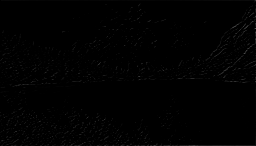

In [ ]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [102]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

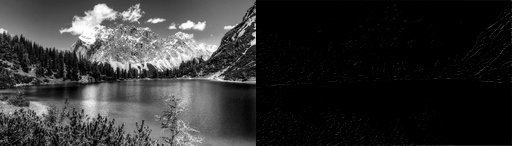

In [ ]:
display(input, output)

### Identity

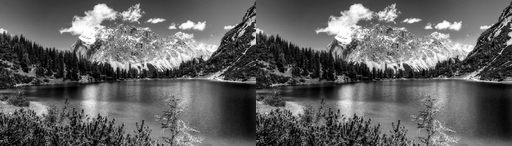

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


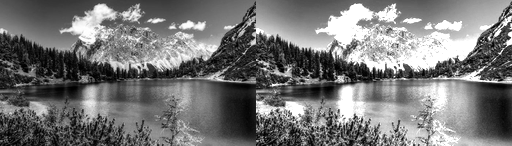

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


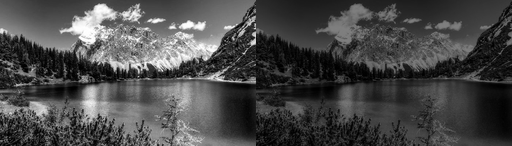

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


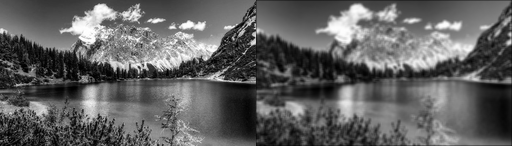

In [ ]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


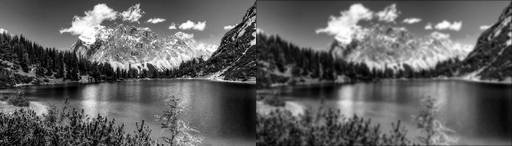

In [ ]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


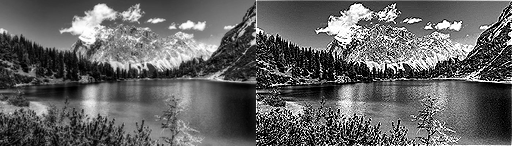

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


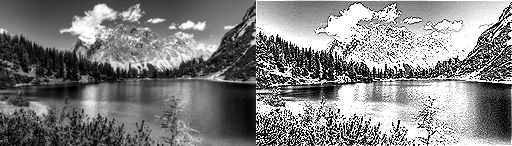

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


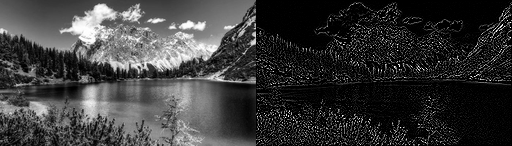

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

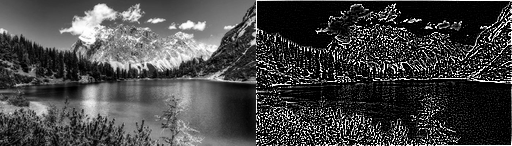

In [ ]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

In [ ]:
# TODO: Challenge, hard image with hard transformations

# Ejercicios Extras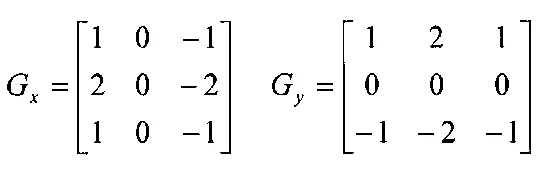

1. Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

Comenzamos leyendo la imagen que vamos a usar

In [115]:
img = Image.open('/content/image2.jpeg')
img.thumbnail((512, 512), Image.ANTIALIAS)

img = np.array(img).astype(np.uint8)

<ipython-input-115-874e7d00cc3e>:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((512, 512), Image.ANTIALIAS)


Transformamos a escala de grises

In [116]:
gray_img = np.round(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]).astype(np.uint8)


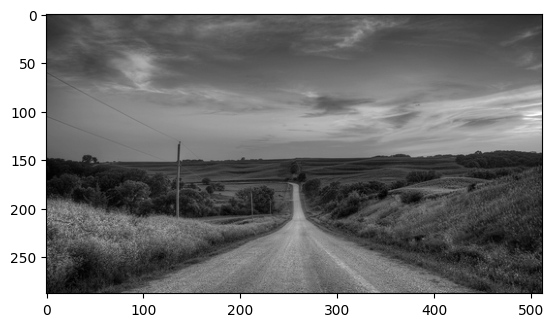

In [117]:
plt.imshow(gray_img,cmap='gray')
plt.show()

#### Definición de filtros

#### Prewit

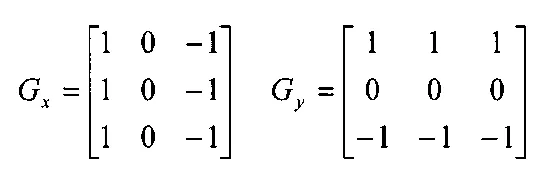

In [118]:
prewit_horizontal = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewit_vertical = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

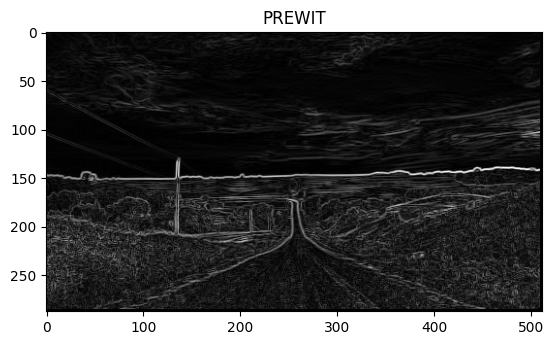

In [120]:
# Tamaño imagen original
h, w = gray_img.shape

# Nueva imagen vacía
new_img = np.zeros((h, w))

# Iterar el operador en la imagen en escala de grises
for i in range(1, h - 1):
    for j in range(1, w - 1):
        horizontalGrad = (prewit_horizontal[0, 0] * gray_img[i - 1, j - 1]) + \
                         (prewit_horizontal[0, 1] * gray_img[i - 1, j]) + \
                         (prewit_horizontal[0, 2] * gray_img[i - 1, j + 1]) + \
                         (prewit_horizontal[1, 0] * gray_img[i, j - 1]) + \
                         (prewit_horizontal[1, 1] * gray_img[i, j]) + \
                         (prewit_horizontal[1, 2] * gray_img[i, j + 1]) + \
                         (prewit_horizontal[2, 0] * gray_img[i + 1, j - 1]) + \
                         (prewit_horizontal[2, 1] * gray_img[i + 1, j]) + \
                         (prewit_horizontal[2, 2] * gray_img[i + 1, j + 1])

        verticalGrad = (prewit_vertical[0, 0] * gray_img[i - 1, j - 1]) + \
                       (prewit_vertical[0, 1] * gray_img[i - 1, j]) + \
                       (prewit_vertical[0, 2] * gray_img[i - 1, j + 1]) + \
                       (prewit_vertical[1, 0] * gray_img[i, j - 1]) + \
                       (prewit_vertical[1, 1] * gray_img[i, j]) + \
                       (prewit_vertical[1, 2] * gray_img[i, j + 1]) + \
                       (prewit_vertical[2, 0] * gray_img[i + 1, j - 1]) + \
                       (prewit_vertical[2, 1] * gray_img[i + 1, j]) + \
                       (prewit_vertical[2, 2] * gray_img[i + 1, j + 1])

        # Ajustar imagen
        mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
        new_img[i - 1, j - 1] = mag

# Gráfico de imagen
plt.figure()
plt.title('PREWIT')
plt.imshow(new_img, cmap='gray')
plt.show()

#### Sobel

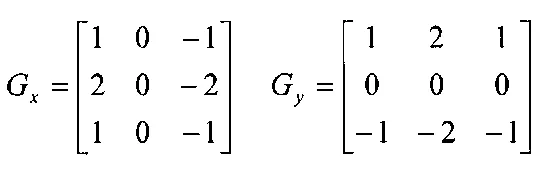

In [121]:
# Filtro Sobel
sobel_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


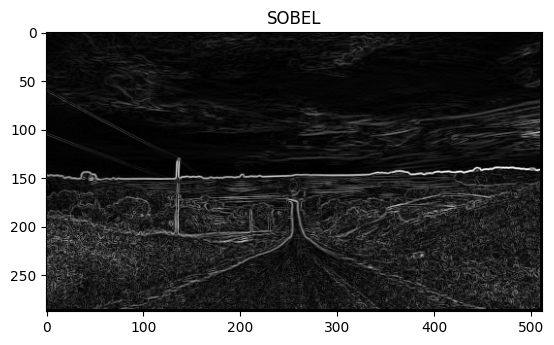

In [122]:
# Tamaño imagen inicial
h, w = gray_img.shape

# Imagenes iniciales
nueva_horizontal = np.zeros((h, w))
nueva_vertical = np.zeros((h, w))
nueva_imagen = np.zeros((h, w))

# offset by 1
for i in range(1, h - 1):
    for j in range(1, w - 1):
        horizontalGrad = (sobel_horizontal[0, 0] * gray_img[i - 1, j - 1]) + \
                         (sobel_horizontal[0, 1] * gray_img[i - 1, j]) + \
                         (sobel_horizontal[0, 2] * gray_img[i - 1, j + 1]) + \
                         (sobel_horizontal[1, 0] * gray_img[i, j - 1]) + \
                         (sobel_horizontal[1, 1] * gray_img[i, j]) + \
                         (sobel_horizontal[1, 2] * gray_img[i, j + 1]) + \
                         (sobel_horizontal[2, 0] * gray_img[i + 1, j - 1]) + \
                         (sobel_horizontal[2, 1] * gray_img[i + 1, j]) + \
                         (sobel_horizontal[2, 2] * gray_img[i + 1, j + 1])

        nueva_horizontal[i - 1, j - 1] = abs(horizontalGrad)

        verticalGrad = (sobel_vertical[0, 0] * gray_img[i - 1, j - 1]) + \
                       (sobel_vertical[0, 1] * gray_img[i - 1, j]) + \
                       (sobel_vertical[0, 2] * gray_img[i - 1, j + 1]) + \
                       (sobel_vertical[1, 0] * gray_img[i, j - 1]) + \
                       (sobel_vertical[1, 1] * gray_img[i, j]) + \
                       (sobel_vertical[1, 2] * gray_img[i, j + 1]) + \
                       (sobel_vertical[2, 0] * gray_img[i + 1, j - 1]) + \
                       (sobel_vertical[2, 1] * gray_img[i + 1, j]) + \
                       (sobel_vertical[2, 2] * gray_img[i + 1, j + 1])

        nueva_vertical[i - 1, j - 1] = abs(verticalGrad)

        # Edge Magnitude
        mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
        nueva_imagen[i - 1, j - 1] = mag

plt.figure()
plt.title('SOBEL')
plt.imshow(nueva_imagen, cmap='gray')
plt.show()

### Laplaciano

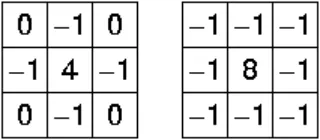

Haciendo uso de la lógica aprendida al inicio del Notebook utilizaremos tensores para realizar el ejercicio

Leemos la imagen, y la pasamos a tensor en escala de grises con la función "to_tensor" definida en ejercicios anteriores

In [123]:
input = to_tensor(Image.open('/content/image2.jpeg'))
input.shape

torch.Size([1, 1080, 1920])

Filtro Laplaciano -- en sus dos versiones

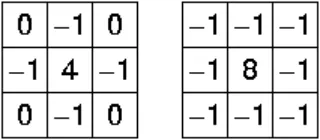

Utilizamos su primer versión y lo aplicamos sencillamente como en los ejercicios anteriores

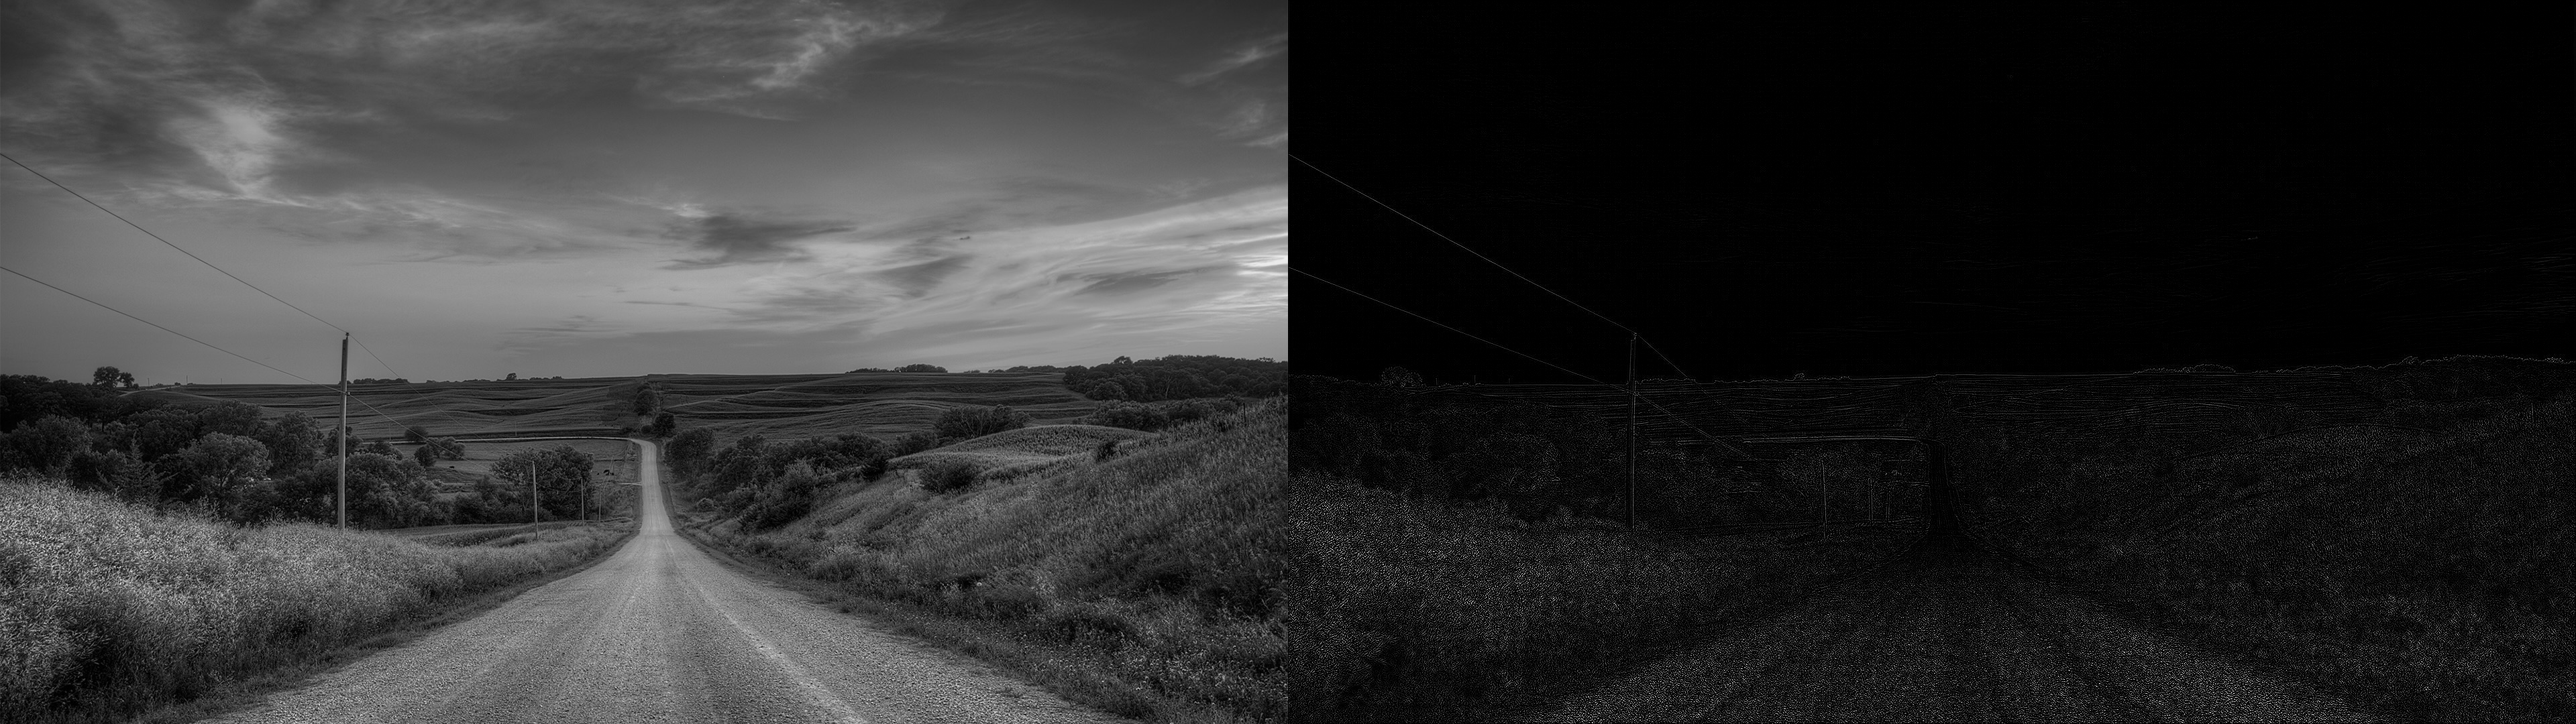

In [124]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
output = conv(input)
display(input, output)

**Conclusión 1:** Tanto el filtro de Sobel o Prewit funcionan mejor en términos de calidad para definir líneas, al realizar un ajuste tanto vertical como Horizontal sobre la imagen. Sin embargo, el filtro laplaciano es más eficiente computacionalmente al sólo ser una operación matricial, en lugar de 2 (vertical y horizontal) como se realiza en los otros filtros.

2. Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

 Tomando como base la aplicación del filtro de sobel

In [125]:
# Tomamos la maggnitud calculada del Sobel anterior
magnitud = np.uint8(mag)

Aplicación de alpga para realzar

In [126]:
# Aplicamos alfa = 0.5 para realzar las líneas
lineas = 0.5 * magnitud.astype(np.float32)

Construcción de nueva imagen al restar las líneas

<Figure size 640x480 with 0 Axes>

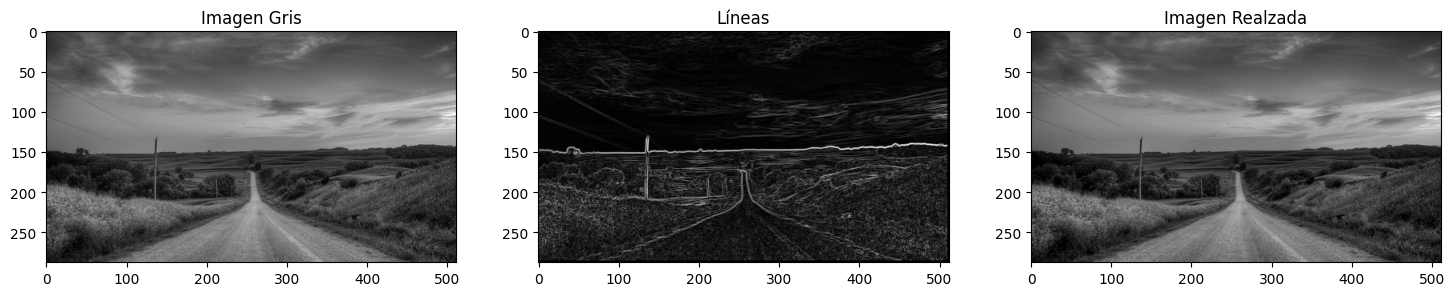

In [127]:
# Restar las líneas de la imagen en gris
imagen_nueva = (gray_img.astype(np.float32) - lineas).clip(0, 255).astype(np.uint8)

plt.clf()
plt.figure(figsize=(18, 10))
plt.subplot(131), plt.imshow(gray_img, cmap='gray'), plt.title('Imagen Gris')
plt.subplot(132), plt.imshow(nueva_imagen, cmap='gray'), plt.title('Líneas')
plt.subplot(133), plt.imshow(imagen_nueva, cmap='gray'), plt.title('Imagen Realzada')
plt.show()



3. Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes